# IMDB_Dataset_Analysis

# Import all necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /users/maaqib/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Dataset_Loading

In [2]:
import pandas as pd

# Load the IMDB dataset
data = pd.read_csv('IMDB_Dataset.csv')

# Check the first few rows
print(data.head())

# Check the shape of the dataset
print(f"Dataset shape: {data.shape}")


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Dataset shape: (50000, 2)


In [4]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = text.split()  # Tokenize words
    text = [word for word in text if word not in stop_words]  # Remove stop words
    return ' '.join(text)

data['review'] = data['review'].apply(preprocess_text)
data.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production br br filming tech...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake thinks zombie...,negative
4,petter mattei love time money visually stunnin...,positive


# Data_Distribution

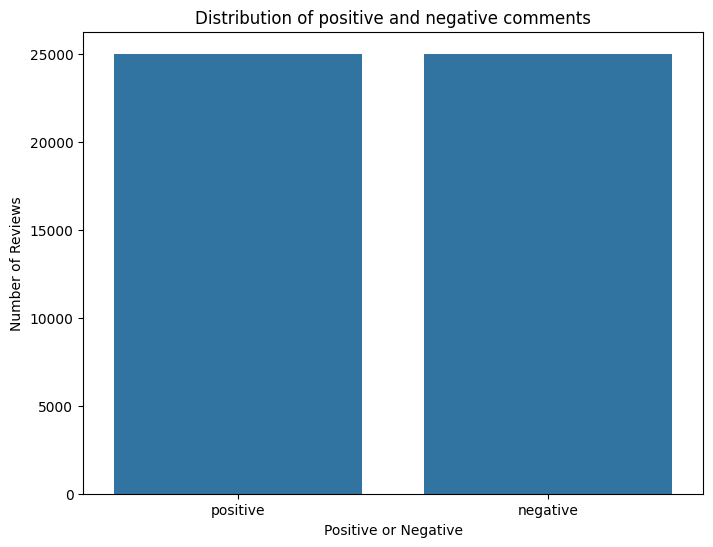

positive    50.0
negative    50.0
Name: sentiment, dtype: float64


In [19]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=data)
plt.title('Distribution of positive and negative comments')
plt.xlabel('Positive or Negative')
plt.ylabel('Number of Reviews')
plt.show()

distribution = data['sentiment'].value_counts(normalize=True) * 100 
print(distribution)

In [20]:
data["review"][0]

'one reviewers mentioned watching 1 oz episode hooked right exactly happened br br first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word br br called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away br br would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches d

In [6]:
count_vectorizer = CountVectorizer(ngram_range=(2, 2))  # Bigram model
X_ngrams = count_vectorizer.fit_transform(data['review'])
print(X_ngrams.shape)

(50000, 3099540)


In [7]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(data['review'])
print(X_tfidf.shape)

(50000, 5000)


# Word2Vec FE

In [11]:
from gensim.models import Word2Vec

reviews = [review.split() for review in data['review']]
word2vec_model = Word2Vec(reviews, vector_size=100, window=5, min_count=2)
word2vec_model.wv.most_similar('movie')

[('film', 0.8415212035179138),
 ('flick', 0.6778373718261719),
 ('movies', 0.6478146910667419),
 ('think', 0.5733338594436646),
 ('guess', 0.5648370385169983),
 ('really', 0.5565622448921204),
 ('sure', 0.5378596782684326),
 ('thats', 0.5376774072647095),
 ('honestly', 0.5299195647239685),
 ('sequel', 0.5291598439216614)]

In [12]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

sample_text = "This is a movie review."
inputs = tokenizer(sample_text, return_tensors='pt')
outputs = model(**inputs)

# Model_Training and Accuray

Accuracy: 0.8911
Precision: 0.8817162736760726
Recall: 0.9053383607858703
F1 Score: 0.8933711935768138


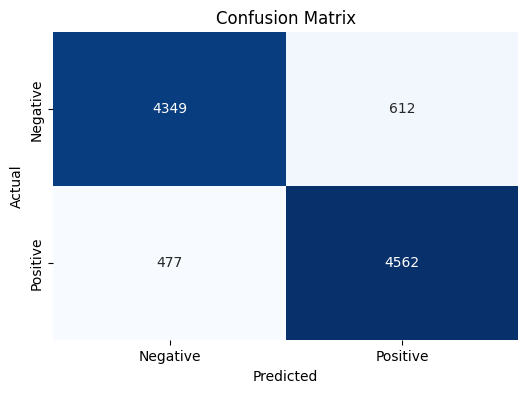

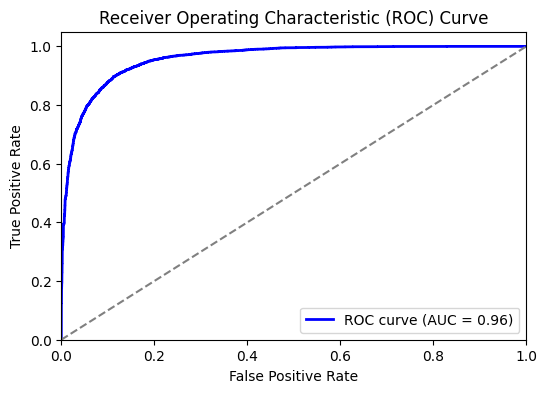

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming data is already preprocessed and you have X_tfidf (TF-IDF features) and 'sentiment' column
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, data['sentiment'], test_size=0.2, random_state=42)

# Train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set (binary predictions)
y_pred = model.predict(X_test)

# Predict probabilities (for ROC curve)
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='positive')
recall = recall_score(y_test, y_pred, pos_label='positive')
f1 = f1_score(y_test, y_pred, pos_label='positive')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob, pos_label='positive')
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


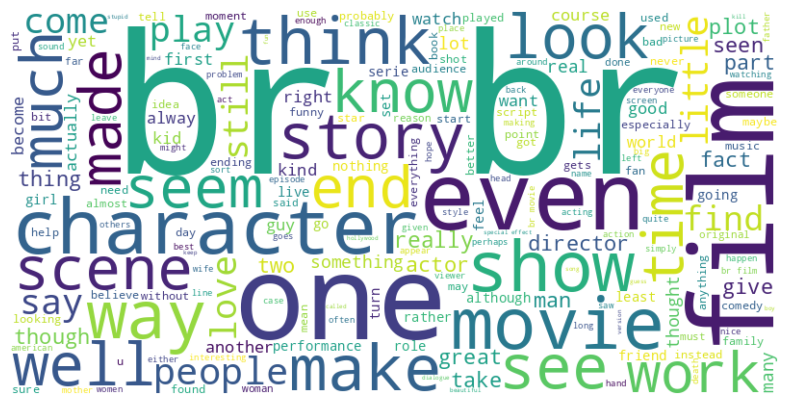

In [16]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data['review']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()